# Named Entity Recognition

## Getting Started

In this project, the goal is to creat a good machine learning model to classify named entities in the text. This is an information extraction project where we try to extract the following classes: 
-  geo = Geographical Entity
-  org = Organization
-  per = Person
-  gpe = Geopolitical Entity
-  tim = Time Indicator
-  art = Artifact
-  eve = Event
-  nat = Natural Phenomenon

The given dataset is an annotated corpus from GMB (Groningen Meaning Bank)

## Exploring the Data

The code cell below loads necessary Python libraries and load the annotated corpus data. Note that the last column from this dataset, `'Tag'`, will be our target label (the category to which an individual word belongs to). The first column is an index and can be ignored. Rest of the columns correspond to the `'sentence'`, `'Word'`, and the Part-of-speech `'POS'` notation respectively - These are the features about each individual word.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as fn

from IPython.display import display  # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

data = pd.read_table('dataset_05-22-2018.txt')

# Set a random seed for reproducibility
np.random.seed(0)

display(data.head(5))

,Unnamed: 0,Sentence #,Word,POS,Tag
0,0,1.0,Thousands,NNS,O
1,1,1.0,of,IN,O
2,2,1.0,demonstrators,NNS,O
3,3,1.0,have,VBP,O
4,4,1.0,marched,VBN,O


Before we move onto the models, first step is to look for missing values. The following code cell calculates the number of missing values in each colum. In this dataset, every feature and label are available and so there is no need to worry about missing values

In [36]:
missing_values_count = data.isnull().sum()
missing_values_count[0:]

Unnamed: 0    0
Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [37]:
n_words = data['Word'].count()
n_sentences = data['Sentence #'].nunique()

print("Total number of sentences: {}".format(n_sentences))
print("Total number of words: {}".format(n_words))

Total number of sentences: 2999
Total number of words: 66161


In [38]:
data.describe(include=['O'])

,Word,POS,Tag
count,66161,66161,66161
unique,8766,41,17
top,the,NN,O
freq,3292,9307,56217


The dataset has 8766 unique words & 9307 nouns. 

In [39]:
data['Tag'].value_counts(normalize=True)

O        0.849700
B-geo    0.031287
B-org    0.018697
I-per    0.018651
B-gpe    0.018591
B-tim    0.017533
B-per    0.016732
I-org    0.013996
I-geo    0.006257
I-tim    0.005048
B-art    0.000801
B-eve    0.000680
I-eve    0.000559
I-art    0.000514
I-gpe    0.000514
B-nat    0.000302
I-nat    0.000136
Name: Tag, dtype: float64

85% of the words does not come under 'Named entities'. This is basically a classification problem and since there is lot of skewness in the data, it is not right to consider "Prediction Accuracy" as a validation metric. Simply predicting every word as 'O' would give an accuracy of 85% but it's of no real use. We will look at F1-score as a validation metric (this is the harmonic mean of Precision & Recall).

-  Precision answers the question: "What proportion of positive identifications are actually correct?" [higher the False-Positives lower the Precision]

It is a ratio of true positives(words classified as entities, and which are actually entitites) to all positives(all words classified as entities, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`


-  Recall answers the question: "What proportion of actual positives are identified correctly?" [higher the False-Negatives, lower the Recall]

It is a ratio of true positives(words classified as entities, and which are actually entities) to all the words that were actually entities, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`


## Baseline Model
Before we proceed with feature generation and machine learning algorithms, we need a baseline model. A simplest model would be a 'memorization algorithm'. i.e. just remember the most common named entity for every word and predict that. Incase, we don't know that word, predict 'O'.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        '''
        Expects a list of words as X and a list of tags as y.
        '''
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
    
    def predict(self, X, y=None):
        '''
        Predict the the tag from memory. If word is unknown, predict 'O'.
        '''
        return [self.memory.get(x, 'O') for x in X]

This is a multi-class classification problem and hence it is good to look at the precision and recall for each class. This is achieved using `classification_report`. Also, report is printed and the over all F1-score is calculated excluding the non-entity class `O`.

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

words = data['Word'].values.tolist()
tags = data['Tag'].values.tolist()

labels = ['I-art', 'B-gpe', 'B-art', 'I-per', 'I-eve', \
          'B-org', 'B-eve', 'B-geo', 'I-org', 'I-geo', \
          'B-nat', 'I-tim', 'I-gpe', 'B-tim', 'I-nat', 'B-per']

pred = cross_val_predict(estimator=fn.MemoryTagger(), X=words, y=tags, cv=10)
base_model = classification_report(y_pred = pred, y_true = tags, labels=labels)
print(base_model)

             precision    recall  f1-score   support

      I-art       0.00      0.00      0.00        34
      B-gpe       0.86      0.71      0.77      1230
      B-art       0.00      0.00      0.00        53
      I-per       0.73      0.42      0.53      1234
      I-eve       0.42      0.30      0.35        37
      B-org       0.59      0.41      0.49      1237
      B-eve       0.18      0.09      0.12        45
      B-geo       0.69      0.70      0.69      2070
      I-org       0.66      0.46      0.54       926
      I-geo       0.56      0.46      0.51       414
      B-nat       0.44      0.20      0.28        20
      I-tim       0.36      0.19      0.25       334
      I-gpe       0.50      0.09      0.15        34
      B-tim       0.87      0.75      0.81      1160
      I-nat       0.80      0.44      0.57         9
      B-per       0.75      0.53      0.62      1107

avg / total       0.70      0.55      0.61      9944



For the memorization model, `'Precision'` for named entities is good but `'Recall'` is low implying relatively large amount of 'False Negatives'. This makes sense as our model inherently is designed that way - we assign 'O', if there is no memory of that word which is a 'False Negative'. This acts as our baseline model and now we will perform feature engineering apply machine learning algorithms to get better results.

## Feature Generation

In NLP, some of the important features are:
1. Words
     -  Current word (essentially like a learned dictionary)
     -  previous/previous-previous/next/next-next words (helps in understanding the context)
2. Linguistic classification
     -  Part-of-speech tags (POS)
3. Word substrings (particularly useful with scientific/biological terms)
4. Word shapes
     -  length, capitalization, titlecase, numerals etc.,
5. lemma - root stem, i.e often times the word you end up with, is not something you look up in a dictionary, but you can look up a lemma. Prev/next lemma also gives information about the context

Some of the above mentioned features are extracted for the words in the dataset in next few code cells.


In [42]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

In [43]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()
pos = data['POS'].values.tolist()
lemma = [lemmatizer.lemmatize(words[i].decode('8859'),get_wordnet_pos(pos[i])) for i in range(len(words))]

The idea of Natural Language Processing is to do some form of analysis, or processing, where the machine can understand, at least to some level, what the text means, says, or implies. One of the major forms of pre-processing is filtering out useless data. Often times some words carry more meaning than the others; we can also see that some words are plain useless and we use them as filler words, ex: of, the, a, an etc., In natural language processing, useless words (data), are referred to as stop words. In the nltk.corpus, there are a set of words that are defined as 'stopwords'. All of these words are non-objects and hence I feel this can be a useful feature. Nearly 30% of the total data set are 'stopwords'. 

In [44]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

stop_word = [bool(True) if i in stop_words else bool(False) for i in words]

In [45]:
data['stop_word'] = pd.Series(stop_word)
data['lemma'] = pd.Series(lemma)

In [46]:
data.head(5)

,Unnamed: 0,Sentence #,Word,POS,Tag,stop_word,lemma
0,0,1.0,Thousands,NNS,O,False,Thousands
1,1,1.0,of,IN,O,True,of
2,2,1.0,demonstrators,NNS,O,False,demonstrator
3,3,1.0,have,VBP,O,True,have
4,4,1.0,marched,VBN,O,False,march


Here, the data is given in terms of annotated words. Using words alone while splitting into test/train sets will result in data bleeding. To avoid this, first we need to convert words into sentences. This is implemented using a class `SentenceGetter` in the next code cell.

In [47]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, k, l, t) for w, p, k, l, t in zip(s["Word"].values.tolist(),
                                                                       s["POS"].values.tolist(),
                                                                       s["lemma"].values.tolist(),
                                                                       s["stop_word"].values.tolist(),
                                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [48]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [49]:
print(sentences[0])

[('Thousands', 'NNS', u'Thousands', False, 'O'), ('of', 'IN', u'of', True, 'O'), ('demonstrators', 'NNS', u'demonstrator', False, 'O'), ('have', 'VBP', u'have', True, 'O'), ('marched', 'VBN', u'march', False, 'O'), ('through', 'IN', u'through', True, 'O'), ('London', 'NNP', u'London', False, 'B-geo'), ('to', 'TO', u'to', True, 'O'), ('protest', 'VB', u'protest', False, 'O'), ('the', 'DT', u'the', True, 'O'), ('war', 'NN', u'war', False, 'O'), ('in', 'IN', u'in', True, 'O'), ('Iraq', 'NNP', u'Iraq', False, 'B-geo'), ('and', 'CC', u'and', True, 'O'), ('demand', 'VB', u'demand', False, 'O'), ('the', 'DT', u'the', True, 'O'), ('withdrawal', 'NN', u'withdrawal', False, 'O'), ('of', 'IN', u'of', True, 'O'), ('British', 'JJ', u'British', False, 'B-gpe'), ('troops', 'NNS', u'troop', False, 'O'), ('from', 'IN', u'from', True, 'O'), ('that', 'DT', u'that', True, 'O'), ('country', 'NN', u'country', False, 'O'), ('.', '.', u'.', False, 'O')]


Different features, as mentioned earlier, corresponding to each word are extracted using the functions in the following code cell. 

In [50]:
def word2features(data, i):
    
    ''' Expects a sentence (as printed above) and the index for the word
    as input and returns the features corresponding to that word as a dict'''
    
    Word = data[i][0]
    POS = data[i][1]
    lemma = data[i][2]
    stop_word = data[i][3]
    tag = data[i][4]
    features = {
        'Word': Word,
        'POS': POS,
        'lemma': lemma,
        'stop_word': stop_word,
        'tag': tag,
        'lowercase': Word.islower(),
        'uppercase': Word.isupper(),
        'titlecase': Word.istitle(),
        'digit': Word.isdigit(),
    }
    if i == 1:
        prev_word = data[i-1][0]
        prev_pos = data[i-1][1]
        prev_lemma = data[i-1][2]
        features.update({
            'prev_word': prev_word,
            'prev_pos': prev_pos,
            'prev_lemma': prev_lemma,
            'prev_prev_word': '__Start2__',
            'prev_prev_pos': '__Start2__',
            'prev_prev_lemma': '__Start2__',
            'lowercase_prev': prev_word.islower(),
            'titlecase_prev': prev_word.istitle(),
            'uppercase_prev': prev_word.isupper(),
            'digit_prev': prev_word.isdigit(),
        })
    elif i > 1:
        prev_word = data[i-1][0]
        
        features.update({
            'prev_word': prev_word,
            'prev_pos': data[i-1][1],
            'prev_lemma': data[i-1][2],
            'prev_prev_word': data[i-2][0],
            'prev_prev_pos': data[i-2][1],
            'prev_prev_lemma':data[i-2][2],
            'titlecase_prev': prev_word.istitle(),
            'lowercase_prev': prev_word.islower(),
            'uppercase_prev': prev_word.isupper(),
            'digit_prev': prev_word.isdigit(),
        })

    elif i == 0:
        
        features.update({
            'prev_word': '__Start1__',
            'prev_pos': '__Start1__',
            'prev_lemma': '__Start1__',
            'prev_prev_word': '__Start1__',
            'prev_prev_pos': '__Start1__',
            'prev_prev_lemma': '__Start1__',
            'lowercase_prev': '__Start1__',
            'titlecase_prev': '__Start1__',
            'uppercase_prev': '__Start1__',
            'digit_prev': '__Start1__',
        })


    if i < len(data)-2:
        next_word = data[i+1][0]
        
        features.update({
            'next_word': next_word,
            'next_pos': data[i+1][1],
            'next_lemma': data[i+1][2],
            'next_next_word': data[i+2][0],
            'next_next_lemma': data[i+2][2],
            'next_next_pos': data[i+2][1],
            'titlecase_next': next_word.istitle(),
            'uppercase_next': next_word.isupper(),
            'lowercase_next': next_word.islower(),
            'digit_next': next_word.isdigit(),
        })

    elif i == (len(data)-2):
        next_word = data[i+1][0]
        
        features.update({
            'next_word': next_word,
            'next_pos': data[i+1][1],
            'next_lemma': data[i+1][2],
            'next_next_word': '__End2__',
            'next_next_lemma': '__End2__',
            'next_next_pos': '__End2__',
            'lowercase_next': next_word.islower(),
            'titlecase_next': next_word.istitle(),
            'uppercase_next': next_word.isupper(),
            'digit_next': next_word.isdigit(),
        })

    elif i == (len(data)-1):
        
        features.update({
            'next_word': '__End1',
            'next_pos': '__End1',
            'next_lemma': '__End1',
            'next_next_word': '__End1__',
            'next_next_lemma': '__End1__',
            'next_next_pos': '__End1__',
            'lowercase_next': '__End1__',
            'titlecase_next': '__End1__',
            'uppercase_next': '__End1__',
            'digit_next': '__End1__',
        })

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


In [51]:
features_final = [sent2features(s) for s in sentences]

features_transient = [pd.DataFrame.from_dict(sent) for sent in features_final]
features = pd.concat(features_transient, ignore_index = True)
print("{} total after feature engineering (including 'Tag' column).".format(len(list(features.columns))))
display(features.sample(5))

29 total after feature engineering (including 'Tag' column).


,POS,Word,digit,digit_next,digit_prev,lemma,lowercase,lowercase_next,lowercase_prev,next_lemma,...,prev_prev_word,prev_word,stop_word,tag,titlecase,titlecase_next,titlecase_prev,uppercase,uppercase_next,uppercase_prev
21522,.,.,False,__End1__,False,.,False,__End1__,False,__End1,...,Red,Sea,False,O,False,__End1__,True,False,__End1__,False
49967,VBN,released,False,False,False,release,True,False,True,Thursday,...,a,statement,False,O,False,True,False,False,False,False
53599,DT,the,False,False,False,the,True,True,True,virus,...,exposure,to,True,O,False,False,False,False,False,False
14914,",",",",False,False,True,",",False,True,False,but,...,in,1954,False,O,False,False,False,False,False,False
43514,DT,the,False,False,False,the,True,True,True,city,...,part,of,True,O,False,False,False,False,False,False


In [52]:
features_final = features.drop('tag', axis=1)
Tags = features['tag']

All the features generated are either boolean expressions or strings. There is no need to perform normalization or any kind of transformation on this data. However, we should use a label encoder or conver all the string into a number respresentation for the algorithm to understand. Here I used LabelEncoder from the preprocessing toolkit. 

In [53]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for column_name in features_final.columns:
    if features_final[column_name].dtype == object:
        features_final[column_name] = le.fit_transform(features_final[column_name])
    else:
        pass

Here I tried three supervised learning algorithms to see their relative performance: RandomForest, GradientBoosting and Conditional random field classifiers.

In [54]:
from sklearn.ensemble import RandomForestClassifier

clf_B = RandomForestClassifier(random_state = 10)
y_pred_RF = cross_val_predict(estimator=clf_B, X=features_final, y=Tags, cv=5)
report_RF = classification_report(Tags, y_pred_RF, labels=labels)
print(report_RF)

             precision    recall  f1-score   support

      I-art       0.25      0.03      0.05        34
      B-gpe       0.69      0.67      0.68      1230
      B-art       0.00      0.00      0.00        53
      I-per       0.70      0.82      0.76      1234
      I-eve       0.17      0.08      0.11        37
      B-org       0.54      0.47      0.50      1237
      B-eve       0.35      0.13      0.19        45
      B-geo       0.60      0.75      0.66      2070
      I-org       0.56      0.50      0.53       926
      I-geo       0.52      0.46      0.49       414
      B-nat       0.00      0.00      0.00        20
      I-tim       0.74      0.41      0.52       334
      I-gpe       0.23      0.09      0.13        34
      B-tim       0.74      0.59      0.66      1160
      I-nat       0.00      0.00      0.00         9
      B-per       0.69      0.67      0.68      1107

avg / total       0.63      0.62      0.62      9944



In [55]:
from sklearn.ensemble import GradientBoostingClassifier

clf_A = GradientBoostingClassifier(random_state = 10)

y_pred_GB = cross_val_predict(estimator=clf_A, X=features_final, y=Tags, cv=5)
report_GB = classification_report(Tags, y_pred_GB, labels=labels)
print(report_GB)

             precision    recall  f1-score   support

      I-art       0.00      0.00      0.00        34
      B-gpe       0.76      0.70      0.73      1230
      B-art       0.09      0.04      0.05        53
      I-per       0.72      0.87      0.79      1234
      I-eve       0.28      0.14      0.18        37
      B-org       0.63      0.49      0.55      1237
      B-eve       0.46      0.13      0.21        45
      B-geo       0.62      0.81      0.70      2070
      I-org       0.64      0.53      0.58       926
      I-geo       0.62      0.49      0.54       414
      B-nat       0.25      0.20      0.22        20
      I-tim       0.74      0.38      0.50       334
      I-gpe       0.16      0.09      0.11        34
      B-tim       0.81      0.63      0.71      1160
      I-nat       0.40      0.22      0.29         9
      B-per       0.71      0.73      0.72      1107

avg / total       0.68      0.66      0.66      9944



## Conditional Random Field Algorithm

To see the performance, a simple CRF algorithm is tried here using the sklearn_crfsuite toolkit. This considers the conditional probabilities in predictions. It is successfully applied in many NLP applications. 

sklearn_crfsuite requires the inputs to be in the form of dict. Hence slight modification is done for the inputs and is implemented in the follwoing code cells.

In [56]:
def word2features1(data, i):
    
    ''' Expects a sentence (as printed above) and the index for the word
    as input and returns the features corresponding to that word as a dict'''
    
    Word = data[i][0]
    POS = data[i][1]
    lemma = data[i][2]
    stop_word = data[i][3]
    tag = data[i][4]
    features = {
        'Word': Word,
        'POS': POS,
        'lemma': lemma,
        'stop_word': stop_word,
        'lowercase': Word.islower(),
        'uppercase': Word.isupper(),
        'titlecase': Word.istitle(),
        'digit': Word.isdigit(),
    }
    if i == 1:
        prev_word = data[i-1][0]
        prev_pos = data[i-1][1]
        prev_lemma = data[i-1][2]
        features.update({
            'prev_word': prev_word,
            'prev_pos': prev_pos,
            'prev_lemma': prev_lemma,
            'prev_prev_word': '__Start2__',
            'prev_prev_pos': '__Start2__',
            'prev_prev_lemma': '__Start2__',
            'lowercase_prev': prev_word.islower(),
            'titlecase_prev': prev_word.istitle(),
            'uppercase_prev': prev_word.isupper(),
            'digit_prev': prev_word.isdigit(),
        })
    elif i > 1:
        prev_word = data[i-1][0]
        
        features.update({
            'prev_word': prev_word,
            'prev_pos': data[i-1][1],
            'prev_lemma': data[i-1][2],
            'prev_prev_word': data[i-2][0],
            'prev_prev_pos': data[i-2][1],
            'prev_prev_lemma':data[i-2][2],
            'titlecase_prev': prev_word.istitle(),
            'lowercase_prev': prev_word.islower(),
            'uppercase_prev': prev_word.isupper(),
            'digit_prev': prev_word.isdigit(),
        })

    elif i == 0:
        
        features.update({
            'prev_word': '__Start1__',
            'prev_pos': '__Start1__',
            'prev_lemma': '__Start1__',
            'prev_prev_word': '__Start1__',
            'prev_prev_pos': '__Start1__',
            'prev_prev_lemma': '__Start1__',
            'lowercase_prev': '__Start1__',
            'titlecase_prev': '__Start1__',
            'uppercase_prev': '__Start1__',
            'digit_prev': '__Start1__',
        })


    if i < len(data)-2:
        next_word = data[i+1][0]
        
        features.update({
            'next_word': next_word,
            'next_pos': data[i+1][1],
            'next_lemma': data[i+1][2],
            'next_next_word': data[i+2][0],
            'next_next_lemma': data[i+2][2],
            'next_next_pos': data[i+2][1],
            'titlecase_next': next_word.istitle(),
            'uppercase_next': next_word.isupper(),
            'lowercase_next': next_word.islower(),
            'digit_next': next_word.isdigit(),
        })

    elif i == (len(data)-2):
        next_word = data[i+1][0]
        
        features.update({
            'next_word': next_word,
            'next_pos': data[i+1][1],
            'next_lemma': data[i+1][2],
            'next_next_word': '__End2__',
            'next_next_lemma': '__End2__',
            'next_next_pos': '__End2__',
            'lowercase_next': next_word.islower(),
            'titlecase_next': next_word.istitle(),
            'uppercase_next': next_word.isupper(),
            'digit_next': next_word.isdigit(),
        })

    elif i == (len(data)-1):
        
        features.update({
            'next_word': '__End1',
            'next_pos': '__End1',
            'next_lemma': '__End1',
            'next_next_word': '__End1__',
            'next_next_lemma': '__End1__',
            'next_next_pos': '__End1__',
            'lowercase_next': '__End1__',
            'titlecase_next': '__End1__',
            'uppercase_next': '__End1__',
            'digit_next': '__End1__',
        })

    return features

def sent2features1(sent):
    return [word2features1(sent, i) for i in range(len(sent))]

def sent2labels1(sent):
    return [label for word, pos, lemma, stopword, label in sent]

In [57]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

X = [sent2features1(s) for s in sentences]
y = [sent2labels1(s) for s in sentences]

y_pred_crf = cross_val_predict(estimator=crf, X=X, y=y, cv=10)
report_crf = flat_classification_report(y_pred = y_pred_crf, y_true=y, labels=labels)
print(report_crf)

C:\Users\YathishPC\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      I-art       0.00      0.00      0.00        34
      B-gpe       0.81      0.72      0.76      1230
      B-art       0.00      0.00      0.00        53
      I-per       0.82      0.90      0.86      1234
      I-eve       0.44      0.19      0.26        37
      B-org       0.65      0.60      0.63      1237
      B-eve       0.56      0.22      0.32        45
      B-geo       0.71      0.82      0.76      2070
      I-org       0.70      0.73      0.72       926
      I-geo       0.68      0.63      0.65       414
      B-nat       0.22      0.10      0.14        20
      I-tim       0.72      0.50      0.59       334
      I-gpe       0.14      0.06      0.08        34
      B-tim       0.90      0.80      0.85      1160
      I-nat       0.67      0.22      0.33         9
      B-per       0.80      0.77      0.78      1107

avg / total       0.75      0.74      0.74      9944



In [58]:
def classificationReport2dict(report):
    lines = report.split('\n')
    classes = {}
    
    classes.update({'Precision': lines[19].split()[3],
                   'Recall': lines[19].split()[4],
                   'F1-Score': lines[19].split()[5],})
    
    return classes

In [100]:
A = classificationReport2dict(base_model)
A.update({'Algorithm':'Memory Tagger',})
B = classificationReport2dict(report_RF)
B.update({'Algorithm':'Random Forest',})
C = classificationReport2dict(report_GB)
C.update({'Algorithm':'Gradient Boosting',})
D = classificationReport2dict(report_crf)
D.update({'Algorithm':'Conditional Random Field',})
results = [A,B,C,D]
metrics = pd.DataFrame.from_dict(results)
display(metrics)

,Algorithm,F1-Score,Precision,Recall
0,Memory Tagger,0.61,0.70,0.55
1,Random Forest,0.62,0.63,0.62
2,Gradient Boosting,0.66,0.68,0.66
3,Conditional Random Field,0.74,0.75,0.74


We shall compare RandomForest & GradientBoosting algorithms. MemoryTagger is not a good idea as it just remembers the data. From the cross_validation reports, it is evident (F1-scores) that GradientBoosting algorithm does better than RandomForest. Also the overall average F1-score is 0.66 for GradientBoosting algorithm & 0.63 for RandomForest. Note that class 'O' is excluded in calculating the overall F1-score. Also, one thing to note is that `'Recall'` has improved significantly when ML models are used.
CRF does better than RF and GB, but it is not optimized here as it was used in Stanford CoreNLP.

Conditional random field algorithm performs much better on the dataset. The precision, recall and over all F1-score imporved to 0.74. Tuning the regularization parameters might yield better results. GridSearch and complexity curves would reveal more information and help in tuning the model for optimum performance. 

Importance of context in NER, skewness in the data, large volume of data and large number of features involved makes CRF a good algorithm for this particular data set. Also, F1-score is highest for CRF algorith. I will go ahead with CRF and perform a grid search optimization over the entire training set by tuning at least one parameter to improve upon the untuned model's F1-score. 

In NER problems, we shall be careful while doing a test train split. We have to do the split on the sentences so that we don't loose the context and avoid data bleeding. This is implemented in the following cell. The sentences are first split and then every word in those train sets is used for training

In [69]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} sentences.".format(len(X_train)))
print("Testing set has {} sentences.".format(len(X_test)))

Training set has 2399 sentences.
Testing set has 600 sentences.


## Model Tuning (Grid Search)
Inorder to tune the model to get optimal parameters, we can employ techniques like GridSearchCV and RandomizedSearchCV.
-  These are techniques that are used to find the optimal hyper parameters for the model
-  Select the hyperparameters that might improve the model (based on intuition) and then fit the model with all combinations of parameters. Calculate the evaluation metric F1-score and find the optimal combination. Use that to finally make the model
-  In gridsearch, model is validated using k-fold cross-validation: divide the data into k bins and use k-1 bins for training and the remaining bin for testing. We repeat this process k times and finally calculate the average error which will be the generalized error. This will remove/reduce the bias in the data if any. ShuffleSplit is another cross-validation technique which is implemented in this. In the following implementation, it creates 5 shuffled sets, and for each shuffle, 20%('test_size') of data will be used as validation set. It helps to avoid overfitting.

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn_crfsuite.metrics import flat_f1_score
from scipy.stats import expon

clf = CRF(algorithm='lbfgs',
          max_iterations=100,
          all_possible_transitions=True)

param_dist = {"c1": expon(scale = 0.5),
              "c2": expon(scale = 0.05)}

scorer = make_scorer(flat_f1_score, labels= labels, average = 'weighted')

cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)

grid_obj = RandomizedSearchCV(clf, param_dist, scoring=scorer, cv=cv_sets, verbose = 0, n_iter = 25)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
best_parameters = grid_fit.best_params_
print(best_parameters)

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print("Unoptimized model\n----------------------")
print(flat_classification_report(y_test, predictions, labels = labels))
print("Optimized model\n----------------------")
print(flat_classification_report(y_test, best_predictions, labels = labels))

{'c2': 0.018117123574024716, 'c1': 0.31760548772707742}
Unoptimized model
----------------------
             precision    recall  f1-score   support

      I-art       0.00      0.00      0.00         7
      B-gpe       0.84      0.82      0.83       244
      B-art       0.00      0.00      0.00        16
      I-per       0.83      0.95      0.89       276
      I-eve       1.00      0.33      0.50         6
      B-org       0.68      0.62      0.65       256
      B-eve       1.00      0.29      0.44         7
      B-geo       0.75      0.86      0.80       392
      I-org       0.71      0.75      0.73       193
      I-geo       0.70      0.63      0.67        68
      B-nat       0.00      0.00      0.00         5
      I-tim       0.78      0.45      0.57        86
      I-gpe       1.00      0.11      0.20         9
      B-tim       0.94      0.75      0.84       258
      I-nat       0.00      0.00      0.00         5
      B-per       0.87      0.85      0.86       255



As we see in the calssification report, optimized model has better F1-score and other evaluation metrics.

## Analyzing Model Performance

### Learning Curves
Here, we'll take a look at the models' learning and testing performances on various subsets of training data. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

In [87]:
from sklearn.model_selection import learning_curve

def ModelLearning(X, y, regressor):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    
    cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state = 0)
    
    scorer = make_scorer(flat_f1_score,labels = labels,average = 'weighted')
    
    train_sizes = np.rint(np.linspace(1, len(X)*0.8 - 1, 9)).astype(int)

    sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = scorer, verbose=0)
        
        # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    plt.figure(figsize=(7,5))
    plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(sizes, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(sizes, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
    plt.title('Learning Curve')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Number of sentences in Training set')
    plt.ylabel('F1-Score')
    plt.ylim([-0.05,1.05])
    plt.xlim([0, len(X)*0.8])
    plt.show()

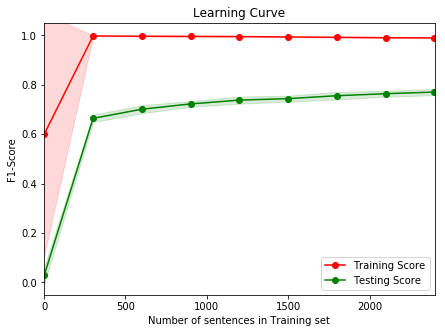

In [88]:
ModelLearning(X,y,best_clf)

The above learning curves are generated using weighted average f1-score for all named-entities ('O' is excluded from the f1-score calculation). If 'O' is also included then test f1-score will also be close to train f1-score. These curves are useful in finding out if the model is limited by data. validation score is increasing marginally with increase in data points, but it is not very significant after 2000 sentences. It looks like the algorithm is not limited by data. But we need to be careful about multiple classes that are present. It is possible to look at scores of each class seperately and see how each class is being affected by addition of more data.  

### Complexity Curves
The following two code cells produces a graph for a conditional random field model that has been trained and validated on the dataset using different values for the first order regularization parameter 'C1'. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `scorer` function.

In [94]:
from sklearn.model_selection import validation_curve

def ModelComplexity(X, y, best_clf):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

    c1 = np.arange(0.0, 1, 0.05)
    
    scorer = make_scorer(flat_f1_score, labels = labels, average = 'weighted')    

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(best_clf, X, y, \
        param_name = "c1", param_range = c1, cv = cv, scoring = scorer)

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('CRF Complexity Performance')
    plt.plot(c1, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(c1, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(c1, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(c1, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Regularization parameter, C1')
    plt.ylabel('F1-Score')
    plt.ylim([-0.05,1.05])
    plt.show()

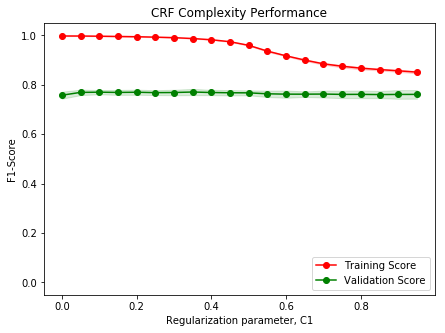

In [95]:
ModelComplexity(X,y,best_clf)

-  The above graph shows the performance of algorithm as we vary the first order regularization parameter, `C1`. Validation score is almost indifferent to the changes in C1. Training score increases as we decrease the C1 and hence the gap between test & train score is increasing. Looking at the training score of close to 1, it looks like the model is getting over fitted. However, we need further exploration to decide on over fitting.  

The following cell shows the most likely and most unlikely transitions from one tag to another as per the optimized algorithm. 

In [98]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(best_clf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(best_clf.transition_features_).most_common()[-20:])

Top likely transitions:
B-art  -> I-art   7.514900
B-eve  -> I-eve   7.158015
I-art  -> I-art   6.668138
I-eve  -> I-eve   6.067339
I-gpe  -> I-gpe   5.507066
B-nat  -> I-nat   5.461355
B-gpe  -> I-gpe   5.460731
B-org  -> I-org   5.260555
I-org  -> I-org   4.826151
B-geo  -> I-geo   4.743480
I-geo  -> I-geo   4.525396
O      -> O       4.497626
B-per  -> I-per   4.346820
I-tim  -> I-tim   3.940976
B-tim  -> I-tim   3.706914
I-per  -> I-per   3.270650
O      -> B-per   2.308072
B-gpe  -> B-org   2.117786
O      -> B-org   1.752272
O      -> B-tim   1.736650

Top unlikely transitions:
B-geo  -> B-geo   -1.565001
B-gpe  -> I-per   -1.582340
B-org  -> I-per   -1.867718
B-per  -> I-org   -1.873048
B-gpe  -> I-geo   -2.037696
I-tim  -> B-tim   -2.264695
B-geo  -> I-tim   -2.281119
B-geo  -> B-per   -2.281602
B-geo  -> I-per   -2.408835
B-gpe  -> I-org   -2.565429
B-geo  -> I-org   -2.637556
I-org  -> I-per   -2.866836
B-tim  -> B-tim   -3.131238
O      -> I-per   -3.214667
I-per  -> B-per  

Results show that algorithm thinks it is highly likely that beginning of an event (B-eve) is followed by a tag inside of an event (I-eve) and such similar things. Also the unlikely transitions are penalized with a negative coefficient

In [101]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(best_clf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(best_clf.state_features_).most_common()[-10:])

Top positive:
4.952642 B-tim    Word:Wednesday
4.952642 B-tim    lemma:Wednesday
4.879709 B-tim    Word:Monday
4.879709 B-tim    lemma:Monday
4.866381 B-tim    lemma:Thursday
4.866381 B-tim    Word:Thursday
4.818657 B-tim    lemma:Tuesday
4.818657 B-tim    Word:Tuesday
4.639730 B-tim    lemma:Sunday
4.639730 B-tim    Word:Sunday

Top negative:
-2.037779 O        prev_word:Rio
-2.037779 O        prev_lemma:Rio
-2.085354 O        Word:end
-2.161337 I-per    prev_prev_pos:DT
-2.219919 O        lemma:decade
-2.285546 B-geo    prev_lemma:recognize
-2.769281 I-gpe    prev_pos:JJ
-2.821084 B-gpe    lowercase
-3.048897 O        Word:day
-4.950461 O        POS:NNP


A look at the top positive state features reveal that the algorithm remembers some of the words or lemmas and try to predict them. The algorithm seems to overfit and probably we need to use better features. One solution to this problem is to carry out principal component analysis on the features and then apply CRF on the most important newly generated compound features. 

## Conclusions:

-  Over all performance of the model from `learning curves` shows that we are not data-limited. But, it is seen that 85% of the data are non-entities and hence create noise in the model. I think, an alternative way is to remove all the words that are classified as `stop_words` (~31%) and then train the algorithm on remaining data - this would reduce the noise and also over-all F1-score would be more meaningful. 
-  As we observed, the CRF algorithm with the generated features seems to overfit the data - can overcome this by doing PCA on the feature set before applying CRF. Significant improvement form the memory_tagger is seen particularly in Recall. 
-  For better performance, we can go for other perceptron and deep neural networks - publicly available libraries for NER like Spacy and Stanford CoreNLP will also improve the algorithm performance.